# 自动微分

## 一个简单的例子

作为一个演示例子，假设我们想对函数$y=2x^Tx$关于列向量$x$求导。

首先，我们创建变量x并为其分配一个初始值。

In [2]:
import torch

x = torch.arange(4.0)
x

tensor([0., 1., 2., 3.])

在我们计算$y$关于$x$的梯度之前，需要一个地方来存储梯度。 重要的是，我们不会在每次对一个参数求导时都分配新的内存。 因为我们经常会成千上万次地更新相同的参数，每次都分配新的内存可能很快就会将内存耗尽。 注意，一个标量函数关于向量$x$的梯度是向量，并且与$x$具有相同的形状。

In [3]:
# 等价于x=torch.arange(4.0,requires_grad=True)
x.requires_grad_(True)
# 默认值是None
x.grad

现在计算$y$。

In [4]:
y = 2 * torch.dot(x, x)
y

tensor(28., grad_fn=<MulBackward0>)

x是一个长度为4的向量，计算x和x的点积，得到了我们赋值给y的标量输出。 接下来，通过调用反向传播函数来自动计算y关于x每个分量的梯度，并打印这些梯度。

In [5]:
y.backward()
x.grad

tensor([ 0.,  4.,  8., 12.])

函数$y=2x^Tx$关于$x$的梯度应为$4x$。 让我们快速验证这个梯度是否计算正确。

In [6]:
x.grad == 4 * x

tensor([True, True, True, True])

现在计算x的另一个函数。

In [7]:
# 在默认情况下，PyTorch会累积梯度，我们需要清除之前的值
x.grad.zero_()
y = x.sum()
y.backward()
x.grad

tensor([1., 1., 1., 1.])

## 非标量变量的反向传播

当y不是标量时，向量y关于向量x的导数的最自然解释是一个矩阵。 对于高阶和高维的y和x，求导的结果可以是一个高阶张量。

然而，虽然这些更奇特的对象确实出现在高级机器学习中（包括深度学习中）， 但当调用向量的反向计算时，我们通常会试图计算一批训练样本中每个组成部分的损失函数的导数。 这里，我们的目的不是计算微分矩阵，而是单独计算批量中每个样本的偏导数之和。

In [8]:
# 对非标量调用backward需要传入一个gradient参数，该参数指定微分函数关于self的梯度。
# 本例只想求偏导数的和，所以传递一个1的梯度是合适的
x.grad.zero_()
y = x * x
# 等价于y.backward(torch.ones(len(x)))，实现标量求导，加快计算
y.sum().backward()
x.grad

tensor([0., 2., 4., 6.])

## 分离计算

有时，我们希望将某些计算移动到记录的计算图之外。 例如，假设y是作为x的函数计算的，而z则是作为y和x的函数计算的。 想象一下，我们想计算z关于x的梯度，但由于某种原因，希望将y视为一个常数， 并且只考虑到x在y被计算后发挥的作用。

这里可以分离y来返回一个新变量u，该变量与y具有相同的值， 但丢弃计算图中如何计算y的任何信息。 换句话说，梯度不会向后流经u到x。 因此，下面的反向传播函数计算z=u*x关于x的偏导数，同时将u作为常数处理， 而不是z=x*x*x关于x的偏导数。

In [9]:
x.grad.zero_()
y = x * x
u = y.detach() # 分离y的值，把它当成常亮
z = u * x

z.sum().backward()
x.grad == u

tensor([True, True, True, True])

由于记录了y的计算结果，我们可以随后在y上调用反向传播， 得到$y=x*x$关于的x的导数，即$2*x$。

In [10]:
x.grad.zero_()
y.sum().backward()
x.grad == 2 * x

tensor([True, True, True, True])

## Python控制流的梯度计算

使用自动微分的一个好处是： 即使构建函数的计算图需要通过Python控制流（例如，条件、循环或任意函数调用），我们仍然可以计算得到的变量的梯度。 在下面的代码中，while循环的迭代次数和if语句的结果都取决于输入a的值。

In [11]:
def f(a):
    b = a * 2
    while b.norm() < 1000:
        b *= 2
    if b.sum() > 0:
        c = b
    else:
        c = 100 * b
    return c

我们来计算这个函数的梯度

In [12]:
a = torch.randn(size=(), requires_grad=True)
d = f(a)
d.backward()

我们现在可以分析上面定义的f函数。 请注意，它在其输入a中是分段线性的。 换言之，对于任何a，存在某个常量标量k，使得f(a)=k*a，其中k的值取决于输入a，因此可以用d/a验证梯度是否正确。

In [13]:
a.grad == d/a

tensor(True)

## 练习

1. 为什么计算二阶导数比一阶导数的开销要更大？

因为会导致结果张量升维

2. 在运行反向传播函数之后，立即再次运行它，看看会发生什么。

In [21]:
a = torch.randn(size=(), requires_grad=True)
d = f(a)
d.backward()
d.backward()

RuntimeError: Trying to backward through the graph a second time (or directly access saved tensors after they have already been freed). Saved intermediate values of the graph are freed when you call .backward() or autograd.grad(). Specify retain_graph=True if you need to backward through the graph a second time or if you need to access saved tensors after calling backward.

3. 在控制流的例子中，我们计算d关于a的导数，如果将变量a更改为随机向量或矩阵，会发生什么？

In [25]:
a = torch.randn(size=(3,), requires_grad=True)
d = f(a)
d.sum().backward()

a.grad == d/a

tensor([True, True, True])

4. 重新设计一个求控制流梯度的例子，运行并分析结果。


In [36]:
def g(a):
    b = a * 3
    if b.norm() > 100:
        b /= 2
    else:
        b *= 2
    c = b * 100
    return c

x = torch.randn(size=(3, 3), requires_grad=True)
y = g(x)
y.sum().backward()

x.grad == y / x, x.grad

(tensor([[False,  True,  True],
         [ True,  True,  True],
         [ True,  True, False]]),
 tensor([[600., 600., 600.],
         [600., 600., 600.],
         [600., 600., 600.]]))

5. 使$f(x)=\sin(x)$，绘制$f(x)$和$\frac{df(x)}{dx}$的图像，其中后者不使用$f'(x)=\cos(x)$。

In [38]:
%matplotlib inline
from matplotlib_inline import backend_inline
from matplotlib import pyplot as plt

def set_figsize(figsize=(3.5, 2.5)):
    backend_inline.set_matplotlib_formats("svg")
    plt.rcParams['figure.figsize'] = figsize

def set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend):
    axes.set_xlabel(xlabel)
    axes.set_ylabel(ylabel)
    axes.set_xscale(xscale)
    axes.set_yscale(yscale)
    axes.set_xlim(xlim)
    axes.set_ylim(ylim)
    if legend:
        axes.legend(legend)
    axes.grid()

def plot(X, Y=None, xlabel=None, ylabel=None, legend=None, xlim=None,
         ylim=None, xscale='linear', yscale='linear',
         fmts=('-', 'm--', 'g-.', 'r:'), figsize=(3.5, 2.5), axes=None):
    """绘制数据点"""
    if legend is None:
        legend = []

    set_figsize(figsize)
    axes = axes if axes else plt.gca()

    # 如果X有一个轴，输出True
    def has_one_axis(X):
        return (hasattr(X, "ndim") and X.ndim == 1 or isinstance(X, list)
                and not hasattr(X[0], "__len__"))

    if has_one_axis(X):
        X = [X]
    if Y is None:
        X, Y = [[]] * len(X), X
    elif has_one_axis(Y):
        Y = [Y]
    if len(X) != len(Y):
        X = X * len(Y)
    axes.cla()
    for x, y, fmt in zip(X, Y, fmts):
        if len(x):
            axes.plot(x, y, fmt)
        else:
            axes.plot(y, fmt)
    set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend)

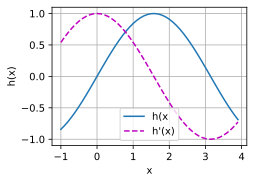

In [53]:
def h(x):
    return torch.sin(x)

x = torch.arange(-1, 4, 0.1, requires_grad=True)
y = h(x)
y.sum().backward()
h = x.grad
new_x = x.detach().numpy()
new_y = y.detach().numpy()
new_h = h
plot(new_x, [new_y, new_h], 'x', 'h(x)', legend=["h(x", "h'(x)"])